# Préparation Réunion 10.12

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Fichiers FQMs

On dispose des fichiers : `fqm_[1-53]_2015`, `fqm_[1-52]_2016` et `fqm_[1-41]_2017`.

On a donc les estimations depuis le 01/01/2015 jusqu'au 22/10/2017.

Erreurs : 
* `fqm_35_2017` : pas d'estimations ... et d'onglet FQM_Definitive
* `fqm_12_2015` : pas de colonne LF% 

On a concaténé les fichiers restants dans une base `fqms_concat.csv`.

In [3]:
fqms = pd.read_csv(r"https://raw.githubusercontent.com/erialc-cal/StatApp_2020/main/temp_dir/fqms_concat_def.csv?token=AOXDVDLYCX63VNU3QJIXEDK72HTS6")

In [4]:
fqms.head(5)

,Unnamed: 0,Jour,Tav,Cie,Ligne,A/D,Aérog,Hor,Sièges Corrections_ICI,Pax Estimés,...,IATA,Cpt Mvt,Faisc. IATA,Date du vol,NB Sieges specif,NB Sieges Standard,Date Equiv,CLE SYNTH.,Semaine,CLE S/T
0,0,1.0,320,EZY,4060,A,OS,08:00:00,180.0,167.22,...,J,1.0,000A,2014-12-29 00:00:00,180,150,2013-12-30 00:00:00,OSA2,1.0,OS1A1
1,1,1.0,320,EZY,4020,A,OS,10:00:00,180.0,167.22,...,J,1.0,000A,2014-12-29 00:00:00,180,150,2013-12-30 00:00:00,OSA2,1.0,OS1A1
2,2,1.0,320,EZY,4062,A,OS,10:25:00,180.0,167.22,...,J,1.0,000A,2014-12-29 00:00:00,180,150,2013-12-30 00:00:00,OSA2,1.0,OS1A1
3,3,1.0,320,EZY,4058,A,OS,11:20:00,180.0,167.22,...,J,1.0,000A,2014-12-29 00:00:00,180,150,2013-12-30 00:00:00,OSA2,1.0,OS1A1
4,4,1.0,320,EZY,4022,A,OS,11:40:00,180.0,167.22,...,J,1.0,000A,2014-12-29 00:00:00,180,150,2013-12-30 00:00:00,OSA2,1.0,OS1A1


In [ ]:
fqms.sort_values(by='Date du vol', ascending=False).head(5)

Il y a un certain nombre de NaN dûs à une erreur de jointure pour l'un des fqms sans doute. Pour l'instant, on va les filtrer en attendant de corriger la jointure. 

In [ ]:
fqms = fqms[fqms['Cie'].isnull()== False]

In [ ]:
fqms.sort_values(by='Date du vol', ascending=False).head(5)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(fqms.sort_values(by='Date du vol', ascending=False).isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-fqms.isnull().sum().sum()/(len(fqms.index)*len(fqms.columns)))*100,'%')

On a une base de données complète de 229 343 estimations de vols :

In [ ]:
fqms.count()

*Attention : les types de plusieurs colonnes sont passées en type 'object', notamment :*
- *les dates dans `Date du vol` et `Date Equiv`, ce qui est corrigé par la ligne de code suivante.*
- *mais aussi des colonnes comme `NB Sièges specif` où certaines valeurs ne sont pas des chiffres (ex : 'nc')...*

In [ ]:
fqms = fqms.astype({'Date du vol': 'datetime64[ns]','Date Equiv': 'datetime64[ns]'})

In [ ]:
fqms.dtypes

## Fichier ENSAE

Le fichier `ENSAE.csv` contient des données par jour allant de 2013 à 2017

In [ ]:
ensae = pd.read_csv(r"https://raw.githubusercontent.com/erialc-cal/StatApp_2020/main/ENSAE.csv?token=AOXDVDKIC36YEGKHHR3P6NK72HXJI",sep=';')

In [ ]:
ensae = ensae.astype({'Jour': 'datetime64[ns]'})

In [ ]:
ensae.head(5)

La base est quasi complète, mais il manque certains faisceaux (géographiques comme de facturation), et beaucoup de valeurs dans la colonne `Total offre sièges` :

In [ ]:
ensae.count()

In [ ]:
ensae.dtypes

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ensae.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-ensae.isnull().sum().sum()/(len(ensae.index)*len(ensae.columns)))*100,'%')

In [ ]:
!pip install --upgrade plotly

In [ ]:
df_2 = ensae.copy()
df_2['Faisceau facturation'] = df_2['Faisceau facturation'].fillna('Inconnu')
df_2['Faisceau géographique'] = df_2['Faisceau géographique'].fillna('N/A')
import plotly.express as px
px.treemap(df_2, path=['Faisceau facturation','Faisceau géographique'])

In [ ]:
corr = ensae.corr()
corr.style.background_gradient(cmap = 'coolwarm')

### Observations Faisceaux et saisonnalité

In [ ]:
df = ensae.copy()
import datetime
df['Jour']=pd.to_datetime(df['Jour'])
df['Annee']= df['Jour'].dt.year
df['Mois']= df['Jour'].dt.month
df['Day']= df['Jour'].dt.day

In [ ]:
faisceaux =['Schengen', 'International', 'Autre UE', 'National', 'Dom Tom']

In [ ]:
df_Schengen = df[df['Faisceau facturation']== 'Schengen']
df_Int = df[df['Faisceau facturation']=='International']
df_UENS = df[df['Faisceau facturation']=='Autre UE']
df_Nat = df[df['Faisceau facturation']=='National']
df_DT = df[df['Faisceau facturation']=='Dom Tom']

Pour le **nombre de passagers réalisés** : 

In [ ]:
colors = ['red','blue', 'green', 'grey', 'purple']
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(25,10))
for i in range(len(faisceaux)):
  df[df['Faisceau facturation']== faisceaux[i]].groupby('Jour').agg({'Nombre de passagers réalisés':'sum'}).plot(ax=axes[0,0],legend=True, subplots=True, color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Annee').agg({'Nombre de passagers réalisés':'sum'}).plot(ax=axes[0,1],legend=True, subplots=True,color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Mois').agg({'Nombre de passagers réalisés':'sum'}).plot(ax=axes[1,0],legend=True, subplots=True,color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Day').agg({'Nombre de passagers réalisés':'sum'}).plot(ax=axes[1,1],legend=True, subplots=True,color=colors[i])
  axes[0,0].legend(faisceaux)
  axes[0,1].legend(faisceaux)
  axes[1,0].legend(faisceaux)
  axes[1,1].legend(faisceaux)
plt.title('Nombre de passagers réalisés par faisceau de facturation')



Comme on peut l'intuiter, la saisonnalité par mois est importante avec un pic de mouvements sur les mois juillet-août. D'autre part, le nombre de passagers est plus important sur la première quinzaine. Sur les 4 années recensées, le nombre de passagers est à la hausse pour les faisceaux Schengen et International surtout.  

In [ ]:
g = sns.FacetGrid(df, col="Faisceau facturation", height=4, aspect=.5)
g.map(sns.barplot, "Type de mouvement", "Nombre de passagers réalisés", order=["Arrivée", "Départ"])

Pour le **nombre de mouvements réalisés** : 

NameError: name 'faisceaux' is not defined

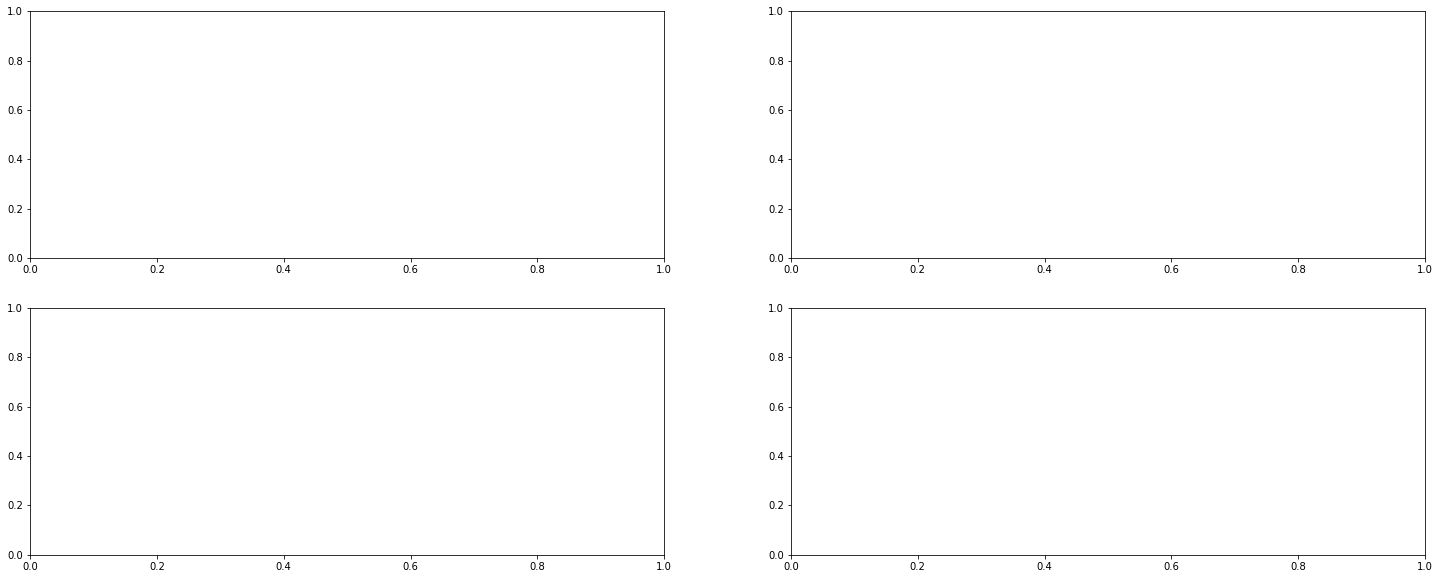

In [5]:
colors = ['red','blue', 'green', 'grey', 'purple']
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(25,10))
for i in range(len(faisceaux)):
  df[df['Faisceau facturation']== faisceaux[i]].groupby('Jour').agg({'Nombre de mouvements réalisés':'sum'}).plot(ax=axes[0,0],legend=True, subplots=True, color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Annee').agg({'Nombre de mouvements réalisés':'sum'}).plot(ax=axes[0,1],legend=True, subplots=True,color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Mois').agg({'Nombre de mouvements réalisés':'sum'}).plot(ax=axes[1,0],legend=True, subplots=True,color=colors[i])
  df[df['Faisceau facturation']==  faisceaux[i]].groupby('Day').agg({'Nombre de mouvements réalisés':'sum'}).plot(ax=axes[1,1],legend=True, subplots=True,color=colors[i])
  axes[0,0].legend(faisceaux)
  axes[0,1].legend(faisceaux)
  axes[1,0].legend(faisceaux)
  axes[1,1].legend(faisceaux)
plt.title('Nombre de mouvements réalisés par faisceau de facturation')



La saisonnalité n'est presque pas influencée par le jour du vol pour les faisceaux Dom Tom, Autre UE, et un peu influencée pour les faisceaux Schengen, national et international avec davantage de mouvements réalisés en début de mois (2 premières semaines). On regarde le nombre de mouvements réalisés par mois, sur 2013 à 2017. Il y a moins de mouvement sur les mois de janvier, février et novembre dans les faisceaux Schengen, national. Le nombre de mouvements réalisés par an est à la hausse pour tous les faisceaux, avec une hausse plus rapide pour le faisceau Schengen.

In [ ]:
g = sns.FacetGrid(df, col="Faisceau facturation", height=4, aspect=.5)
g.map(sns.barplot, "Type de mouvement", "Nombre de mouvements réalisés", order=["Arrivée", "Départ"])

### Ajout d'un taux de remplissage


In [ ]:
ensae['tx_remp']= ensae['Nombre de passagers réalisés'].div(ensae['Total offre sièges'])

## Visualisation

### Etude des FQMs

- Effet du jour de la semaine sur le taux de remplissage estimé :

In [ ]:
jours=['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']

# Toutes les jours sur la même figure :
plt.figure(figsize=(12,6))
for i in range(1,8) :
    sns.kdeplot(fqms['LF%'][fqms['Jour'].isin([i])],label=jours[i-1])
plt.xlabel('Taux de remplissage estimé')
plt.ylabel('Fréquence')
plt.title('Taux de remplissage estimé en fonction du jour de la semaine')
plt.legend()

In [ ]:
# Détail :

fqms_depart = fqms[fqms['A/D'].isin(['D'])]
fqms_arrivee = fqms[fqms['A/D'].isin(['A'])]

fig,ax = plt.subplots(2, 4, figsize=(15, 10)) #, sharey=True
for i in range(7) :
    ax[(i//4,i%4)].set_title(jours[i])
    sns.kdeplot(fqms_depart['LF%'][fqms_depart['Jour'].isin([i+1])],ax=ax[(i//4,i%4)],fill=True, alpha=.3,label='Départ')
    sns.kdeplot(fqms_arrivee['LF%'][fqms_arrivee['Jour'].isin([i+1])],ax=ax[(i//4,i%4)],fill=True, alpha=.3,label='Arrivée')
    ax[(i//4,i%4)].legend()
    
fig.suptitle("Taux de remplissage estimé en fonction du jour de la semaine et du mouvement")

In [ ]:
plt.figure(figsize=(12,6))

sns.boxplot(data=fqms, x="Jour", y="LF%", hue="A/D", palette="pastel")

plt.title("Boxplot du taux de remplissage estimé en fonction du jour de la semaine et du mouvement")

- Effet du faisceau sur le taux de remplissage estimé :

In [ ]:
#Correspondance qualité/faisceau :
fqms[['Faisceau','Qualité']].drop_duplicates()

In [ ]:
faisceaux=['Métropole','Schengen','Dom-Tom','Europe','International']

# Toutes les faisceaux sur la même figure :
plt.figure(figsize=(12,6))
for i in range(1,6) :
    sns.kdeplot(fqms['LF%'][fqms['Faisceau'].isin([i])],label=faisceaux[i-1])
plt.xlabel('Taux de remplissage estimé')
plt.ylabel('Fréquence')
plt.title('Taux de remplissage estimé en fonction du faisceau')
plt.legend()

In [ ]:
#Détail

fig,ax = plt.subplots(2, 3, figsize=(15, 10)) 
for i in range(5) :
    ax[(i//3,i%3)].set_title(faisceaux[i])
    sns.kdeplot(fqms_depart['LF%'][fqms_depart['Faisceau'].isin([i+1])],ax=ax[(i//3,i%3)],fill=True, alpha=.3,label='Départ estimé')
    sns.kdeplot(fqms_arrivee['LF%'][fqms_arrivee['Faisceau'].isin([i+1])],ax=ax[(i//3,i%3)],fill=True, alpha=.3,label='Arrivée')
    ax[(i//3,i%3)].legend()
    
fig.suptitle("Taux de remplissage estimé en fonction du faisceau et du mouvement")

In [ ]:
plt.figure(figsize=(12,6))

sns.boxplot(data=fqms, x="Faisceau", y="LF%", hue="A/D", palette="pastel")

plt.title("Boxplot du taux de remplissage estimé en fonction du faisceau et du mouvement")

### Comparaison des estimations avec les données réelles : 

On compare cette fois le nombre de passagers estimés dans les fqms (colonne `Pax Estimés`) avec les mouvements de passagers effectivement enregistrés dans la base `ENSAE` (colonne `Nombre de passagers réalisés`).

On commence par créer des bases `ensae_depart`et `ensae_arrivee`, et on ne garde que les dates correspondant aux dates des fqms :

In [ ]:
from datetime import date

In [ ]:
ensae_depart = ensae[ensae['Type de mouvement'].isin(['Départ'])]
ensae_depart['Date du Vol'] = ensae_depart['Jour'].dt.date
ensae_depart = ensae_depart[ensae_depart['Date du Vol']>date(2014,12,1)]
ensae_depart = ensae_depart[ensae_depart['Date du Vol']<date(2017,10,23)]

ensae_arrivee = ensae[ensae['Type de mouvement'].isin(['Arrivée'])]
ensae_arrivee['Date du Vol'] = ensae_arrivee['Jour'].dt.date
ensae_arrivee = ensae_arrivee[ensae_arrivee['Date du Vol']>date(2014,12,1)]
ensae_arrivee = ensae_arrivee[ensae_arrivee['Date du Vol']<date(2017,10,23)]

Ensuite, on fait des agrégations pour compter le nombre de passagers estimés par jour et par faisceaux :

In [ ]:
ensae_depart = ensae_depart.groupby(['Date du Vol','Faisceau facturation']).sum('Nombre de passagers réalisés')
ensae_depart = ensae_depart.reset_index()
ensae_arrivee = ensae_arrivee.groupby(['Date du Vol','Faisceau facturation']).sum('Nombre de passagers réalisés')
ensae_arrivee = ensae_arrivee.reset_index()

fqms_depart = fqms_depart.groupby(['Date du vol','Faisceau']).sum('Pax Estimés')
fqms_depart = fqms_depart.reset_index()
fqms_arrivee = fqms_arrivee.groupby(['Date du vol','Faisceau']).sum('Pax Estimés')
fqms_arrivee = fqms_arrivee.reset_index()

In [ ]:
faisceaux_ensae = ['National','Schengen','Dom Tom','Autre UE','International']

fig,ax = plt.subplots(2, 5, figsize=(15, 10)) 
for i in range(5) :
    ax[(0,i)].set_title(faisceaux[i])
    
    sns.kdeplot(fqms_depart['Pax Estimés'][fqms_depart['Faisceau'].isin([i+1])],ax=ax[(0,i)],fill=True, alpha=.3,label='Départs estimés')
    sns.kdeplot(ensae_depart['Nombre de passagers réalisés'][ensae_depart['Faisceau facturation'].isin([faisceaux_ensae[i]])],ax=ax[(0,i)],fill=True, alpha=.3,label='Départs réels')
    
    sns.kdeplot(fqms_arrivee['Pax Estimés'][fqms_arrivee['Faisceau'].isin([i+1])],ax=ax[(1,i)],fill=True, alpha=.3,label='Arrivées estimées')
    sns.kdeplot(ensae_arrivee['Nombre de passagers réalisés'][ensae_arrivee['Faisceau facturation'].isin([faisceaux_ensae[i]])],ax=ax[(1,i)],fill=True, alpha=.3,label='Arrivées réelles')
    
    ax[(0,i)].legend()
    ax[(1,i)].legend()
    
fig.suptitle("Comparaison du nombre de passagers estimé et effectif par faisceaux et type de mouvement")

On peut faire la même chose vis-à-vis des taux de remplissages. 

In [ ]:
ensae_depart = ensae_depart.groupby(['Date du Vol','Faisceau facturation']).mean('tx_remp')
ensae_depart = ensae_depart.reset_index()
ensae_arrivee = ensae_arrivee.groupby(['Date du Vol','Faisceau facturation']).mean('tx_remp')
ensae_arrivee = ensae_arrivee.reset_index()

fqms_depart = fqms_depart.groupby(['Date du vol','Faisceau']).mean('LF%')
fqms_depart = fqms_depart.reset_index()
fqms_arrivee = fqms_arrivee.groupby(['Date du vol','Faisceau']).mean('LF%')
fqms_arrivee = fqms_arrivee.reset_index()

On enlève les valeurs aberrantes dues à des valeurs manquantes dans le calcul du taux de remplissage réel. 

In [ ]:
ensae_arrivee = ensae_arrivee.replace(np.inf, np.NaN)
ensae_arrivee = ensae_arrivee.replace(0, np.NaN)
ensae_depart = ensae_depart.replace(np.inf, np.NaN)
ensae_depart = ensae_depart.replace(0, np.NaN)
ensae_arrivee.sort_values(by='tx_remp')


In [ ]:
faisceaux_ensae = ['National','Schengen','Dom Tom','Autre UE','International']

fig,ax = plt.subplots(2, 5, figsize=(15, 10)) 
for i in range(5) :
    ax[(0,i)].set_title(faisceaux[i])
    
    sns.kdeplot(fqms_depart['LF%'][fqms_depart['Faisceau'].isin([i+1])],ax=ax[(0,i)],fill=True, alpha=.3,label='Départs estimés')
    sns.kdeplot(ensae_depart['tx_remp'][ensae_depart['Faisceau facturation'].isin([faisceaux_ensae[i]])],ax=ax[(0,i)],fill=True, alpha=.3,label='Départs réels')
    
    sns.kdeplot(fqms_arrivee['LF%'][fqms_arrivee['Faisceau'].isin([i+1])],ax=ax[(1,i)],fill=True, alpha=.3,label='Arrivées estimées')
    sns.kdeplot(ensae_arrivee['tx_remp'][ensae_arrivee['Faisceau facturation'].isin([faisceaux_ensae[i]])],ax=ax[(1,i)],fill=True, alpha=.3,label='Arrivées réelles')
    
    ax[(0,i)].legend()
    ax[(1,i)].legend()
    
fig.suptitle("Comparaison des taux de remplissages estimés et réels par faisceaux et type de mouvement")

Etudions la saisonalité dans le taux de remplissage prédit "LF%". Pour cela, par faisceau de facturation, on fait la moyenne de "LF%" par jour, et on la représente graphiquement.

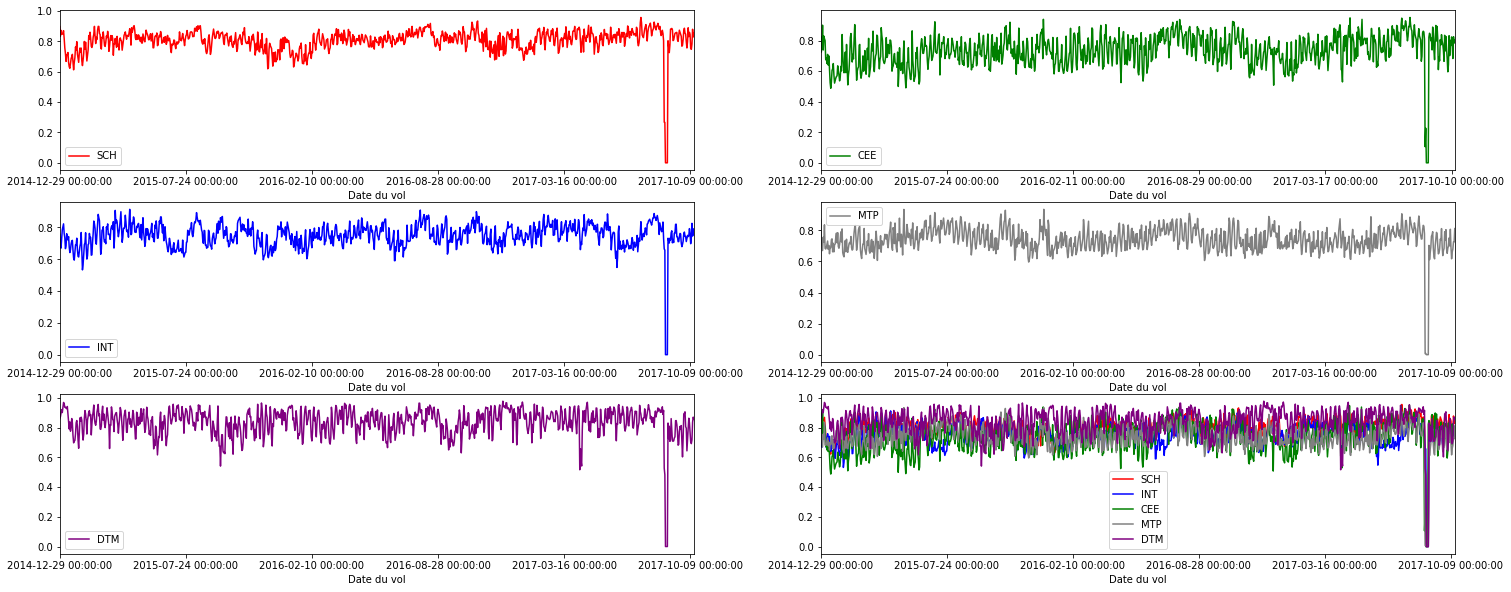

In [6]:
faisceaux_recode =['SCH', 'INT', 'CEE', 'MTP', 'DTM']
#Petit rappel : colors = ['red','blue', 'green', 'grey', 'purple'] 
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(25,10))

fqms[fqms['Qualité']== 'SCH'].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[0,0],legend=True, subplots=True, color=colors[0])
axes[0,0].legend(faisceaux_recode[0:5])

fqms[fqms['Qualité']== 'INT'].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[1,0],legend=True, subplots=True, color=colors[1])
axes[1,0].legend(faisceaux_recode[1:5])

fqms[fqms['Qualité']== 'CEE'].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[0,1],legend=True, subplots=True, color=colors[2])
axes[0,1].legend(faisceaux_recode[2:5])

fqms[fqms['Qualité']== 'MTP'].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[1,1],legend=True, subplots=True, color=colors[3])
axes[1,1].legend(faisceaux_recode[3:5])

fqms[fqms['Qualité']== 'DTM'].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[2,0],legend=True, subplots=True, color=colors[4])
axes[2,0].legend(faisceaux_recode[4:5])

for i in range(len(faisceaux_recode)):
    fqms[fqms['Qualité']== faisceaux_recode[i]].groupby('Date du vol').agg({'LF%':'mean'}).plot(ax = axes[2,1],legend=True, subplots=True, color=colors[i])
axes[2,1].legend(faisceaux_recode)

Le taux de remplissage des avions est très fort en août.